# HW06: Деревья решений и ансамбли

In [69]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import json
import joblib
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, StackingClassifier
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, roc_curve, confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.inspection import permutation_importance
import warnings
warnings.filterwarnings('ignore')
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)
Path('artifacts/figures').mkdir(parents=True, exist_ok=True)
print('OK')

OK


## Загрузка данных

In [70]:
df = pd.read_csv('S06-hw-dataset-01.csv')
print(f'Размер: {df.shape}')
df.head()

Размер: (12000, 30)


,id,num01,num02,num03,num04,num05,num06,num07,num08,num09,...,num20,num21,num22,num23,num24,cat_contract,cat_region,cat_payment,tenure_months,target
0,1,-0.946058,-0.070313,1.824445,-2.754422,0.808865,-0.111094,-0.268950,-3.078210,0.801275,...,-1.616515,-1.989464,1.407390,-0.218362,2.016052,0,2,3,33,0
1,2,-2.484027,0.739378,1.596908,-2.586479,-0.033225,-3.054412,-4.706908,-9.795169,0.145911,...,-1.727040,-0.583997,1.136761,0.285978,-0.310879,2,2,2,102,1
2,3,1.522629,7.159635,-0.564903,-4.493110,1.623610,5.450187,-0.974595,-5.189589,1.600591,...,0.524408,2.022430,1.278358,-0.850547,0.847457,1,0,2,3,0
3,4,0.463373,-1.073908,1.752813,0.362786,2.790872,4.082385,0.322283,3.390984,-0.033929,...,2.399834,-1.431576,-0.746987,0.049639,2.414689,1,0,1,50,0
4,5,3.188390,-4.701692,-0.689918,-0.448995,0.373821,-3.275363,-1.760931,0.923689,0.537345,...,-2.183407,-2.896590,2.440343,-1.097168,1.457323,1,2,3,81,0


In [71]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 30 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             12000 non-null  int64  
 1   num01          12000 non-null  float64
 2   num02          12000 non-null  float64
 3   num03          12000 non-null  float64
 4   num04          12000 non-null  float64
 5   num05          12000 non-null  float64
 6   num06          12000 non-null  float64
 7   num07          12000 non-null  float64
 8   num08          12000 non-null  float64
 9   num09          12000 non-null  float64
 10  num10          12000 non-null  float64
 11  num11          12000 non-null  float64
 12  num12          12000 non-null  float64
 13  num13          12000 non-null  float64
 14  num14          12000 non-null  float64
 15  num15          12000 non-null  float64
 16  num16          12000 non-null  float64
 17  num17          12000 non-null  float64
 18  num18 

In [72]:
print('Пропуски:', df.isnull().sum().sum())
print('\nРаспределение target:')
print(df['target'].value_counts(normalize=True))

Пропуски: 0

Распределение target:
target
0    0.676583
1    0.323417
Name: proportion, dtype: float64


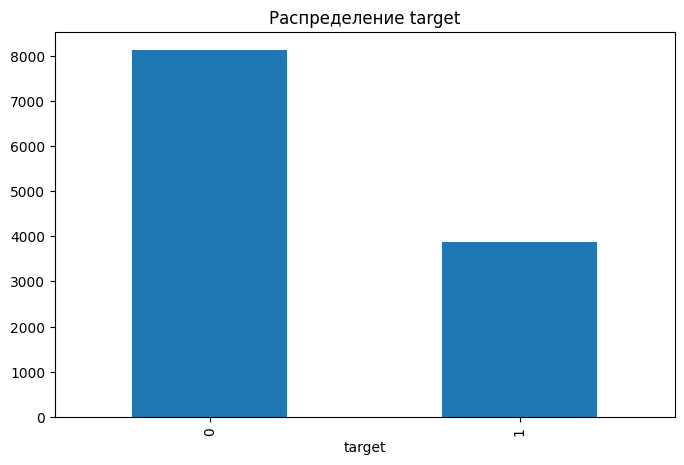

In [73]:
plt.figure(figsize=(8,5))
df['target'].value_counts().plot(kind='bar')
plt.title('Распределение target')
plt.savefig('artifacts/figures/target_distribution.png', dpi=100)
plt.show()

## Train/Test Split

In [74]:
feature_cols = [col for col in df.columns if col not in ['id', 'target']]
X = df[feature_cols]
y = df['target']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_STATE, stratify=y)
print(f'Train: {X_train.shape}, Test: {X_test.shape}')

Train: (9600, 28), Test: (2400, 28)


## Функция для оценки на test

In [75]:
def eval_test_only(model, X_test, y_test):
    return {
        "accuracy": accuracy_score(y_test, model.predict(X_test)),
        "f1": f1_score(y_test, model.predict(X_test)),
        "roc_auc": roc_auc_score(y_test, model.predict_proba(X_test)[:, 1])
    }

## Baseline

In [76]:
dummy_clf = DummyClassifier(strategy='most_frequent', random_state=RANDOM_STATE)
dummy_clf.fit(X_train, y_train)
dummy_metrics = eval_test_only(dummy_clf, X_test, y_test)
print(f'Dummy - Acc: {dummy_metrics["accuracy"]:.4f}, F1: {dummy_metrics["f1"]:.4f}')

Dummy - Acc: 0.6767, F1: 0.0000


In [77]:
lr_pipeline = Pipeline([('scaler', StandardScaler()), ('lr', LogisticRegression(random_state=RANDOM_STATE, max_iter=1000))])
lr_pipeline.fit(X_train, y_train)
lr_metrics = eval_test_only(lr_pipeline, X_test, y_test)
print(f'LogReg - Acc: {lr_metrics["accuracy"]:.4f}, F1: {lr_metrics["f1"]:.4f}, AUC: {lr_metrics["roc_auc"]:.4f}')

LogReg - Acc: 0.8275, F1: 0.7076, AUC: 0.8747


## Decision Tree

In [78]:
dt_param_grid = {'max_depth': [3, 5, 7, 10], 'min_samples_leaf': [1, 5, 10, 20], 'min_samples_split': [2, 10, 20]}
dt_clf = DecisionTreeClassifier(random_state=RANDOM_STATE)
dt_grid = GridSearchCV(dt_clf, dt_param_grid, cv=5, scoring='roc_auc', n_jobs=-1, verbose=1)
dt_grid.fit(X_train, y_train)
print(f'Best params: {dt_grid.best_params_}')
print(f'Best CV AUC: {dt_grid.best_score_:.4f}')
best_dt = dt_grid.best_estimator_
dt_metrics = eval_test_only(best_dt, X_test, y_test)
print(f'DT Test - Acc: {dt_metrics["accuracy"]:.4f}, F1: {dt_metrics["f1"]:.4f}, AUC: {dt_metrics["roc_auc"]:.4f}')

Fitting 5 folds for each of 48 candidates, totalling 240 fits
Best params: {'max_depth': 10, 'min_samples_leaf': 20, 'min_samples_split': 2}
Best CV AUC: 0.9138
DT Test - Acc: 0.8683, F1: 0.7879, AUC: 0.9067


## Random Forest

In [79]:
rf_param_grid = {'n_estimators': [50, 100, 200], 'max_depth': [5, 10, 15, None], 'min_samples_leaf': [1, 5, 10], 'max_features': ['sqrt', 'log2']}
rf_clf = RandomForestClassifier(random_state=RANDOM_STATE)
rf_grid = GridSearchCV(rf_clf, rf_param_grid, cv=5, scoring='roc_auc', n_jobs=-1, verbose=1)
rf_grid.fit(X_train, y_train)
print(f'Best params: {rf_grid.best_params_}')
print(f'Best CV AUC: {rf_grid.best_score_:.4f}')
best_rf = rf_grid.best_estimator_
rf_metrics = eval_test_only(best_rf, X_test, y_test)
print(f'RF Test - Acc: {rf_metrics["accuracy"]:.4f}, F1: {rf_metrics["f1"]:.4f}, AUC: {rf_metrics["roc_auc"]:.4f}')

Fitting 5 folds for each of 72 candidates, totalling 360 fits
Best params: {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'n_estimators': 200}
Best CV AUC: 0.9687
RF Test - Acc: 0.9292, F1: 0.8854, AUC: 0.9673


## Gradient Boosting

In [80]:
gb_param_grid = {'n_estimators': [50, 100, 150], 'learning_rate': [0.01, 0.1, 0.2], 'max_depth': [3, 5, 7], 'min_samples_leaf': [1, 5, 10]}
gb_clf = GradientBoostingClassifier(random_state=RANDOM_STATE)
gb_grid = GridSearchCV(gb_clf, gb_param_grid, cv=5, scoring='roc_auc', n_jobs=-1, verbose=1)
gb_grid.fit(X_train, y_train)
print(f'Best params: {gb_grid.best_params_}')
print(f'Best CV AUC: {gb_grid.best_score_:.4f}')
best_gb = gb_grid.best_estimator_
gb_metrics = eval_test_only(best_gb, X_test, y_test)
print(f'GB Test - Acc: {gb_metrics["accuracy"]:.4f}, F1: {gb_metrics["f1"]:.4f}, AUC: {gb_metrics["roc_auc"]:.4f}')

Fitting 5 folds for each of 81 candidates, totalling 405 fits
Best params: {'learning_rate': 0.2, 'max_depth': 7, 'min_samples_leaf': 10, 'n_estimators': 150}
Best CV AUC: 0.9742
GB Test - Acc: 0.9371, F1: 0.9002, AUC: 0.9718


## Stacking

In [81]:
estimators = [('dt', best_dt), ('rf', best_rf), ('gb', best_gb)]
stacking_clf = StackingClassifier(estimators=estimators, final_estimator=LogisticRegression(random_state=RANDOM_STATE), cv=5)
stacking_clf.fit(X_train, y_train)
stack_metrics = eval_test_only(stacking_clf, X_test, y_test)
print(f'Stacking Test - Acc: {stack_metrics["accuracy"]:.4f}, F1: {stack_metrics["f1"]:.4f}, AUC: {stack_metrics["roc_auc"]:.4f}')

# Получаем предсказания для графиков
y_proba_lr = lr_pipeline.predict_proba(X_test)[:, 1]
y_proba_dt = best_dt.predict_proba(X_test)[:, 1]
y_proba_rf = best_rf.predict_proba(X_test)[:, 1]
y_proba_gb = best_gb.predict_proba(X_test)[:, 1]
y_proba_stack = stacking_clf.predict_proba(X_test)[:, 1]
y_pred_dt = best_dt.predict(X_test)
y_pred_rf = best_rf.predict(X_test)
y_pred_gb = best_gb.predict(X_test)
y_pred_stack = stacking_clf.predict(X_test)

Stacking Test - Acc: 0.9404, F1: 0.9061, AUC: 0.9706


## Сравнение моделей

In [82]:
results = {'Model': ['Dummy', 'LogisticRegression', 'DecisionTree', 'RandomForest', 'GradientBoosting', 'Stacking'], 'Accuracy': [dummy_metrics['accuracy'], lr_metrics['accuracy'], dt_metrics['accuracy'], rf_metrics['accuracy'], gb_metrics['accuracy'], stack_metrics['accuracy']], 'F1-score': [dummy_metrics['f1'], lr_metrics['f1'], dt_metrics['f1'], rf_metrics['f1'], gb_metrics['f1'], stack_metrics['f1']], 'ROC-AUC': [0, lr_metrics['roc_auc'], dt_metrics['roc_auc'], rf_metrics['roc_auc'], gb_metrics['roc_auc'], stack_metrics['roc_auc']]}
results_df = pd.DataFrame(results).sort_values('ROC-AUC', ascending=False)
print(results_df.to_string(index=False))
best_model_name = results_df.iloc[0]['Model']
print(f'\nЛучшая модель: {best_model_name}')

             Model  Accuracy  F1-score  ROC-AUC
  GradientBoosting  0.937083  0.900198 0.971766
          Stacking  0.940417  0.906106 0.970559
      RandomForest  0.929167  0.885445 0.967295
      DecisionTree  0.868333  0.787919 0.906695
LogisticRegression  0.827500  0.707627 0.874691
             Dummy  0.676667  0.000000 0.000000

Лучшая модель: GradientBoosting


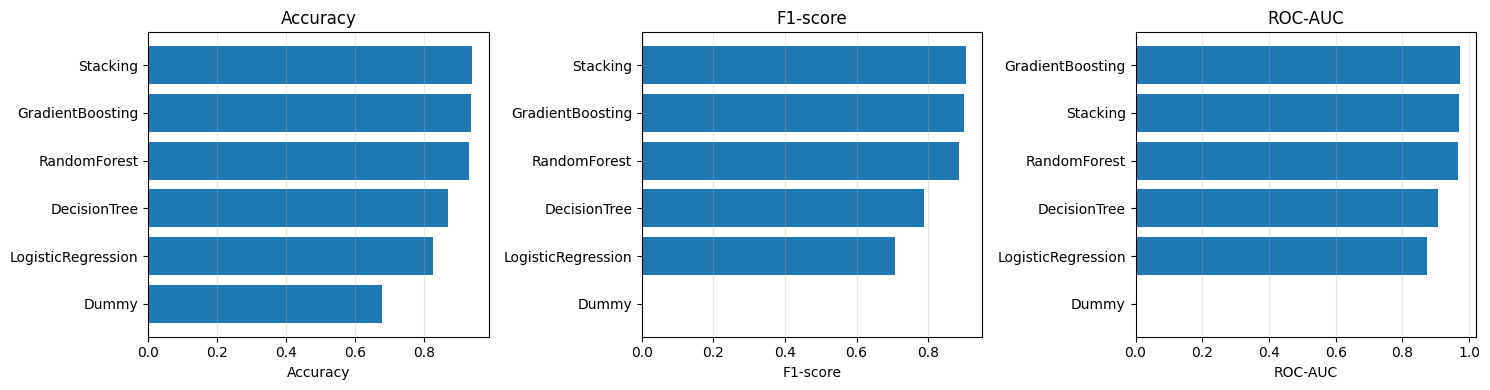

In [83]:
fig, axes = plt.subplots(1, 3, figsize=(15, 4))
for idx, metric in enumerate(['Accuracy', 'F1-score', 'ROC-AUC']):
    data = results_df.sort_values(metric, ascending=True)
    axes[idx].barh(data['Model'], data[metric])
    axes[idx].set_xlabel(metric)
    axes[idx].set_title(metric)
    axes[idx].grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.savefig('artifacts/figures/models_comparison.png', dpi=100)
plt.show()

## ROC-кривые

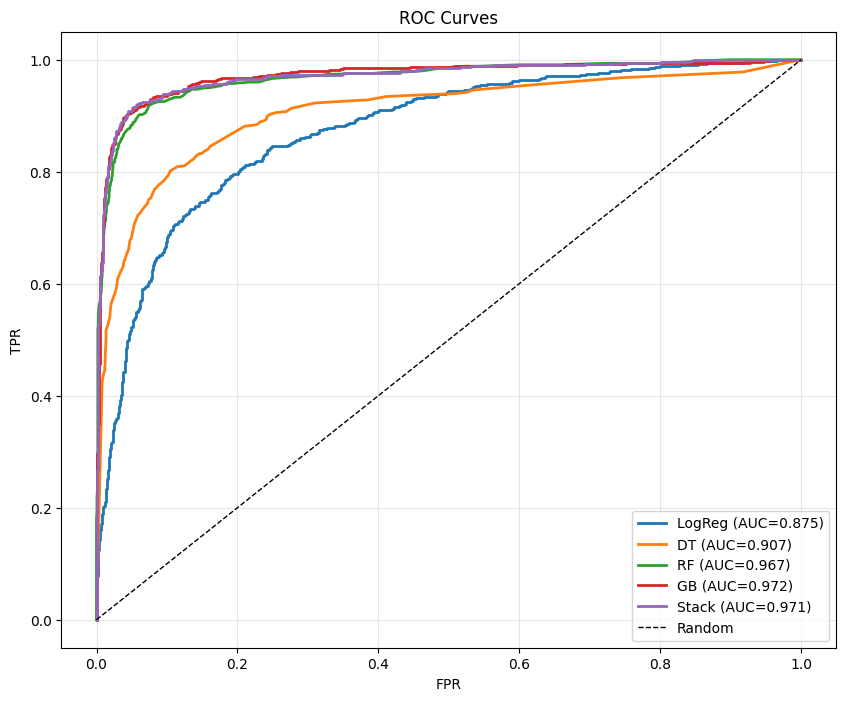

In [84]:
plt.figure(figsize=(10, 8))
for name, y_proba, auc in [('LogReg', y_proba_lr, lr_metrics['roc_auc']), ('DT', y_proba_dt, dt_metrics['roc_auc']), ('RF', y_proba_rf, rf_metrics['roc_auc']), ('GB', y_proba_gb, gb_metrics['roc_auc']), ('Stack', y_proba_stack, stack_metrics['roc_auc'])]:
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    plt.plot(fpr, tpr, label=f'{name} (AUC={auc:.3f})', linewidth=2)
plt.plot([0, 1], [0, 1], 'k--', label='Random', linewidth=1)
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC Curves')
plt.legend()
plt.grid(alpha=0.3)
plt.savefig('artifacts/figures/roc_curves.png', dpi=100)
plt.show()

## Confusion Matrix

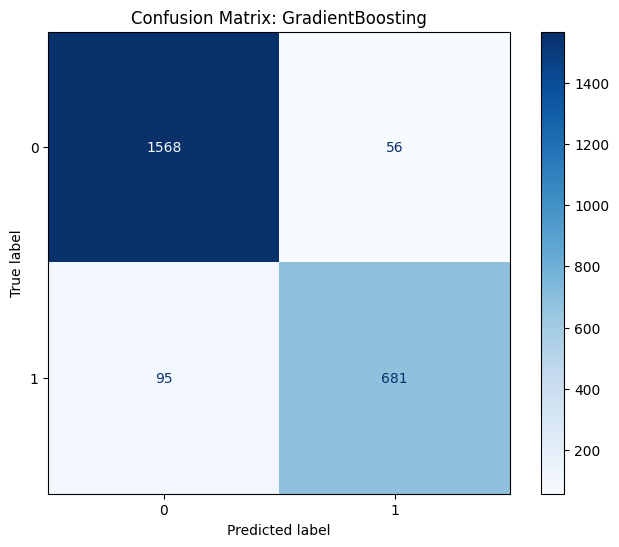

              precision    recall  f1-score   support

           0       0.94      0.97      0.95      1624
           1       0.92      0.88      0.90       776

    accuracy                           0.94      2400
   macro avg       0.93      0.92      0.93      2400
weighted avg       0.94      0.94      0.94      2400



In [85]:
model_preds = {'DecisionTree': y_pred_dt, 'RandomForest': y_pred_rf, 'GradientBoosting': y_pred_gb, 'Stacking': y_pred_stack}
best_pred = model_preds.get(best_model_name, y_pred_gb)
cm = confusion_matrix(y_test, best_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
fig, ax = plt.subplots(figsize=(8, 6))
disp.plot(ax=ax, cmap='Blues', values_format='d')
plt.title(f'Confusion Matrix: {best_model_name}')
plt.savefig('artifacts/figures/confusion_matrix.png', dpi=100)
plt.show()
print(classification_report(y_test, best_pred))

## Permutation Importance

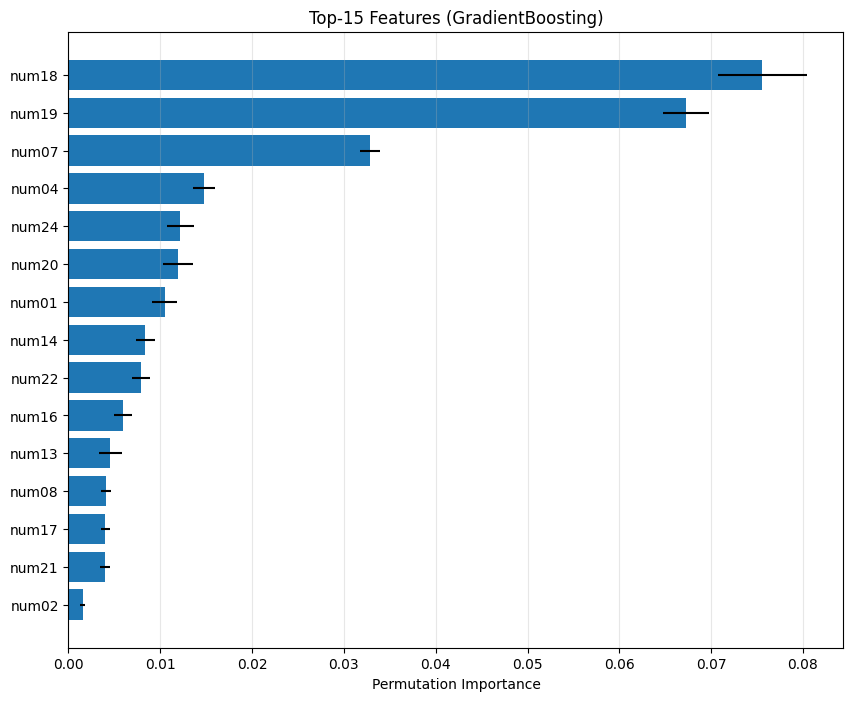

1. num18: 0.0756
2. num19: 0.0673
3. num07: 0.0328
4. num04: 0.0147
5. num24: 0.0122
6. num20: 0.0119
7. num01: 0.0105
8. num14: 0.0084
9. num22: 0.0079
10. num16: 0.0059
11. num13: 0.0045
12. num08: 0.0041
13. num17: 0.0040
14. num21: 0.0040
15. num02: 0.0015


In [86]:
best_models = {'DecisionTree': best_dt, 'RandomForest': best_rf, 'GradientBoosting': best_gb, 'Stacking': stacking_clf}
best_model = best_models.get(best_model_name, best_gb)
perm_imp = permutation_importance(best_model, X_test, y_test, n_repeats=10, random_state=RANDOM_STATE, scoring='roc_auc')
sorted_idx = perm_imp.importances_mean.argsort()[::-1]
top_n = min(15, len(sorted_idx))
plt.figure(figsize=(10, 8))
plt.barh(range(top_n), perm_imp.importances_mean[sorted_idx[:top_n]][::-1], xerr=perm_imp.importances_std[sorted_idx[:top_n]][::-1])
plt.yticks(range(top_n), [feature_cols[i] for i in sorted_idx[:top_n]][::-1])
plt.xlabel('Permutation Importance')
plt.title(f'Top-{top_n} Features ({best_model_name})')
plt.grid(axis='x', alpha=0.3)
plt.savefig('artifacts/figures/feature_importance.png', dpi=100)
plt.show()
for i in range(top_n):
    idx = sorted_idx[i]
    print(f'{i+1}. {feature_cols[idx]}: {perm_imp.importances_mean[idx]:.4f}')

## Сохранение артефактов

In [87]:
with open('artifacts/metrics_test.json', 'w', encoding='utf-8') as f:
    json.dump(results_df.to_dict('records'), f, indent=2, ensure_ascii=False)
search_summaries = {'DecisionTree': {'best_params': dt_grid.best_params_, 'best_cv_score': float(dt_grid.best_score_)}, 'RandomForest': {'best_params': rf_grid.best_params_, 'best_cv_score': float(rf_grid.best_score_)}, 'GradientBoosting': {'best_params': gb_grid.best_params_, 'best_cv_score': float(gb_grid.best_score_)}}
with open('artifacts/search_summaries.json', 'w', encoding='utf-8') as f:
    json.dump(search_summaries, f, indent=2, ensure_ascii=False)
joblib.dump(best_model, 'artifacts/best_model.joblib')
best_model_meta = {'model_name': best_model_name, 'best_params': search_summaries.get(best_model_name, {}).get('best_params', {}), 'test_metrics': {'accuracy': float(results_df[results_df['Model'] == best_model_name]['Accuracy'].values[0]), 'f1_score': float(results_df[results_df['Model'] == best_model_name]['F1-score'].values[0]), 'roc_auc': float(results_df[results_df['Model'] == best_model_name]['ROC-AUC'].values[0])}, 'dataset': 'S06-hw-dataset-01.csv', 'random_state': RANDOM_STATE}
with open('artifacts/best_model_meta.json', 'w', encoding='utf-8') as f:
    json.dump(best_model_meta, f, indent=2, ensure_ascii=False)
print('Все артефакты сохранены!')

Все артефакты сохранены!
